# Reed Muller Codes in 5G
The Reed Muller codes are used in 5G to encode the small payload of control information having a block length between 3 to 11. These codes are linear block codes which generalizes the Reed–Solomon codes and the Walsh–Hadamard code. These codes are
- locally testable, 
- locally decodable, and 
- list decodable.

In this tutorial, we will analyze the bit error rate performance of Reed Muller Codes for different link conditions characterized by signal to noise ratio(SNR). We further will demonstrate the variation in performance with block-length. The content of the tutorial is as follows:

## Table of content:
* [Import Libraries](#import-libraries)
* [Symbol Mapping Configurations](#mapper-and-demapper-parameters)
* [Simulation Parameters](#simulation-parameters)
* [Simulation for BER vs SNR](#simulation)
* [Performance Evaluation](#performance-evaluation)


## Import Libraries 

### Python Libraries

In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import numpy as np

### 5G Toolkit Libraries

In [2]:
from toolkit5G.SymbolMapping import Demapper
from toolkit5G.SymbolMapping import Mapper
from toolkit5G.ChannelCoder  import ReedMullerEncoder5G
from toolkit5G.ChannelCoder  import ReedMullerDecoder5G

In [3]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

## Mapper and Demapper Parameters
Symbol mapping/Demapping is performed for:

- **BPSK** constellation defined by ``constellation_type`` which encodes
- 1 bit per contellation symbol defined by ``num_bits_per_symbol``.
- The demapper generates log likelihood ratios configured by ``hard_out`` 
- using a Log-Map (**"app"**) decoder defined using ``demapping_method``.

In [4]:
constellation_type  = "bpsk"
num_bits_per_symbol = 1
hard_out            = False
demapping_method    = "app"

mapper  = Mapper(constellation_type, num_bits_per_symbol)
demapper= Demapper(demapping_method, constellation_type,  num_bits_per_symbol, hard_out = hard_out)

## Simulation Parameters 
The simulations parameters are:

- ``K`` defines block-length.
- ``SNRdB`` defines Signal to noise ratio (SNR) in dB.
- ``numBatches`` defines number of batches to compute average BER.

In [5]:
K          = np.arange(1,12)
SNRdB      = np.linspace(-10,0,5)
SNR        = 10**(SNRdB/10)
numBatches = 5000

## Simulation
This subsection performs the simulation which involve following steps:

* Bits generation of length ``k``
* Reed Muller Encoding
* BPSK Symbol Mapping of encoded bits
* Passing through the AWGN Channel
    * Adding noise to BPSK symbols with a given SNR
* Symbol De-mapping using **Log Map** Demapper defined by  ``"app"``.
    * Generates Log likelihood values as ``hard_out`` is set to ``False``.
* Reed Muller Decoding
* BER computation

The flow of the implementation can be understood using folowing diagram:
![ReedMuller](RM.png)

The bit error rate (BER) is computed for every combination of K $= \{1,2,3,\dots,11\}$ and SNR $= \{-10, -8, -6, -4, -2, 0\}$ dB and averaged over $500000$ batches (monteCarloIterations).

In [6]:
BER      = np.zeros((K.size, SNR.size))
kIndex   = 0
snrIndex = 0

for k in K:
    #######################################################
    ################ Generate UCI Payload #################
    #######################################################
    bits     = np.random.randint(2, size = (numBatches, k))

    #######################################################
    ################ Reed Muller Encoder ##################
    #######################################################
    codeword = ReedMullerEncoder5G()(bits)

    #######################################################
    ################### Symbol Mapping ####################
    #######################################################
    symbols  = mapper(codeword)
    
    decoder  = ReedMullerDecoder5G(k, hard_out)
    snrIndex = 0
    for snr in SNR:
        
        #######################################################
        ################ Add Noise at Receiver ################
        #######################################################
        symbs    = symbols + np.sqrt(0.5/snr)*(np.random.standard_normal(size=symbols.shape)+1j*np.random.standard_normal(size=symbols.shape)).astype(np.complex64)

        #######################################################
        ################## Symbol Demapping ###################
        #######################################################
        llrEst   = demapper([symbs,  np.float32(1/snr)])

        #######################################################
        ################ Reed Muller Decoder ##################
        #######################################################
        rxBits   = decoder(llrEst)

        #######################################################
        ############## Key Performance Metrics ################
        #######################################################
        BER[kIndex, snrIndex] = np.mean(np.abs(rxBits-bits))
        
        print("For K="+str(k)+", At SNR(dB): "+str(SNRdB[snrIndex])+" | Bit Error Rate: "+str(BER[kIndex, snrIndex]))

        snrIndex = snrIndex + 1
    kIndex = kIndex + 1

For K=1, At SNR(dB): -10.0 | Bit Error Rate: 0.2138
For K=1, At SNR(dB): -7.5 | Bit Error Rate: 0.085
For K=1, At SNR(dB): -5.0 | Bit Error Rate: 0.012
For K=1, At SNR(dB): -2.5 | Bit Error Rate: 0.0002
For K=1, At SNR(dB): 0.0 | Bit Error Rate: 0.0
For K=2, At SNR(dB): -10.0 | Bit Error Rate: 0.2157
For K=2, At SNR(dB): -7.5 | Bit Error Rate: 0.0908
For K=2, At SNR(dB): -5.0 | Bit Error Rate: 0.0116
For K=2, At SNR(dB): -2.5 | Bit Error Rate: 0.0005
For K=2, At SNR(dB): 0.0 | Bit Error Rate: 0.0
For K=3, At SNR(dB): -10.0 | Bit Error Rate: 0.2242
For K=3, At SNR(dB): -7.5 | Bit Error Rate: 0.08566666666666667
For K=3, At SNR(dB): -5.0 | Bit Error Rate: 0.0122
For K=3, At SNR(dB): -2.5 | Bit Error Rate: 0.0006
For K=3, At SNR(dB): 0.0 | Bit Error Rate: 0.0
For K=4, At SNR(dB): -10.0 | Bit Error Rate: 0.21985
For K=4, At SNR(dB): -7.5 | Bit Error Rate: 0.0873
For K=4, At SNR(dB): -5.0 | Bit Error Rate: 0.0141
For K=4, At SNR(dB): -2.5 | Bit Error Rate: 0.00025
For K=4, At SNR(dB): 0.0 |

## Performance Evaluation
The script plots SNR in dB vs BER performance for block-length $\in \{1,2,3,\dots,11\}$. It can be observed that the Reed Muller codes can provide the reliablilty of

- $99.99990 \text{ or BER = } 10^{-4}$ for block-length $\in \{1,2,3,4,5\}$ and,
- $99.99999 \text{ or BER = } 10^{-5}$ for block-length $\in \{1,2,3,\dots,11\}$
at an SNR value of 0 dB. 
Furthermore, the larger codeblock-lengths perform poorer compare to the small block-lengths.

### Performance Plot

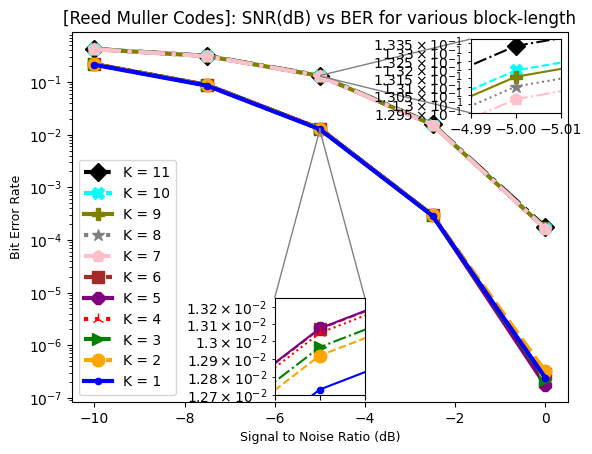

In [7]:
fig, ax = plt.subplots()

color_tuple     = ['blue', 'orange', 'green',   'red',    'purple', 'brown',       'pink',  'gray', 'olive', 'cyan', 'black']
markcolor_tuple = ['gold', 'navy',   'crimson', 'yellow', 'line',   'springgreen', 'black', 'aqua', 'royalblue', 'red', 'green']
linestyle_tuple = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']
marker_tuple    = [".", "o", ">", "2", "8", "s", "p", "*", "P", "X", "D"]


# Make the zoom-in plot:
axins  = zoomed_inset_axes(ax, 100, loc="upper right") # zoom = 100
axins2 = zoomed_inset_axes(ax, 100, loc="lower center") # zoom = 100

kIndex = 10
for k in np.flip(K):
    ax.semilogy(SNRdB, BER[kIndex], color=color_tuple[kIndex%len(color_tuple)], 
                linestyle=linestyle_tuple[kIndex%len(linestyle_tuple)], lw = 3,
                marker=marker_tuple[kIndex%len(marker_tuple)], markersize = 9, label="K = "+str(k))
    axins.semilogy(SNRdB, BER[kIndex], color=color_tuple[kIndex%len(color_tuple)], 
                   linestyle=linestyle_tuple[kIndex%len(linestyle_tuple)], 
                   marker=marker_tuple[kIndex%len(marker_tuple)], markersize = 9, label="K = "+str(k))
    axins2.semilogy(SNRdB, BER[kIndex], color=color_tuple[kIndex%len(color_tuple)], 
                    linestyle=linestyle_tuple[kIndex%len(linestyle_tuple)], 
                    marker=marker_tuple[kIndex%len(marker_tuple)], markersize = 9, label="K = "+str(k))
    
    kIndex = kIndex -1

ax.legend(loc="lower left")
ax.set_xlabel("Signal to Noise Ratio (dB)", fontsize = 9)
ax.set_ylabel("Bit Error Rate", fontsize = 9)
ax.set_title("[Reed Muller Codes]: SNR(dB) vs BER for various block-length")
#I want to select the x-range for the zoomed region. I have figured it out suitable values
# by trial and error. How can I pass more elegantly the dates as something like
# select y-range for zoomed region
x1 = -4.99
x2 = -5.01

# select y-range for zoomed region
y1 = 0.1295
y2 = 0.13375
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

# select y-range for zoomed region
x1 = -4.99
x2 = -5.01

# select y-range for zoomed region
y1 = 0.0127
y2 = 0.01325

axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins2, loc1=1, loc2=2, fc="none", ec="0.5")
plt.draw()


plt.show()